# Imports

In [1]:
import sys
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats 
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
from custom_procs import plot_confusion_matrix

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Task 1

Select what features you'll use. <br>
features_list is a list of strings, each of which is a feature name.<br>
The first feature must be "poi".

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index':'full_name'}, inplace=True)

In [4]:
df.head()

,full_name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
0,ALLEN PHILLIP K,201955,2902,2869717,4484442,NaN,4175000,phillip.allen@enron.com,-126027,-3081055,...,47,1729541,2195,152,65,False,304805,1407,126027,NaN
1,BADUM JAMES P,NaN,NaN,178980,182466,NaN,NaN,NaN,NaN,NaN,...,NaN,257817,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
2,BANNANTINE JAMES M,477,566,NaN,916197,NaN,NaN,james.bannantine@enron.com,-560222,-5104,...,39,4046157,29,864523,0,False,NaN,465,1757552,NaN
3,BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
4,BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,frank.bay@enron.com,-82782,-201641,...,NaN,NaN,NaN,69,NaN,False,NaN,NaN,145796,NaN


In [5]:
# looking at all available features
df.columns

Index(['full_name', 'salary', 'to_messages', 'deferral_payments',
       'total_payments', 'loan_advances', 'bonus', 'email_address',
       'restricted_stock_deferred', 'deferred_income', 'total_stock_value',
       'expenses', 'from_poi_to_this_person', 'exercised_stock_options',
       'from_messages', 'other', 'from_this_person_to_poi', 'poi',
       'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock',
       'director_fees'],
      dtype='object')

In [6]:
# classifying the columns and modifying dataframe
continuous_features = ['salary', 'deferral_payments', 'total_payments', 
                      'loan_advances', 'bonus', 'restricted_stock_deferred', 
                      'deferred_income', 'total_stock_value', 'expenses', 
                      'exercised_stock_options', 'other', 'long_term_incentive',
                      'restricted_stock', 'director_fees', 'to_messages', 
                       'from_poi_to_this_person', 'from_messages', 
                       'from_this_person_to_poi', 'shared_receipt_with_poi']

email_features= ['to_messages', 'from_poi_to_this_person', 'from_messages',
                 'from_this_person_to_poi', 'shared_receipt_with_poi']

for feat in continuous_features:
    df[feat]=df[feat].astype(float)

In [7]:
# check whether all rows with email information are complete
df[email_features].apply(lambda x: x==x).sum(axis=1).value_counts()

5    86
0    60
dtype: int64

In [8]:
# checking the proportion of available data per feature
available_data = pd.DataFrame(
    [{'feature':f,
      'available':df[f].count(),
      'poi':df.query(f'{f}=={f} & poi==True')[f].shape[0],
      'total':df.shape[0]} 
     for f in continuous_features])
available_data=available_data[['feature','total','available','poi']]
available_data['prop_available']=available_data.available/available_data.total
available_data['prop_poi_total']=available_data.poi/available_data.total
available_data['propr_poi_available']=available_data.poi/available_data.available
available_data

,feature,total,available,poi,prop_available,prop_poi_total,propr_poi_available
0,salary,146,95,17,0.650685,0.116438,0.178947
1,deferral_payments,146,39,5,0.267123,0.034247,0.128205
2,total_payments,146,125,18,0.856164,0.123288,0.144000
3,loan_advances,146,4,1,0.027397,0.006849,0.250000
4,bonus,146,82,16,0.561644,0.109589,0.195122
5,restricted_stock_deferred,146,18,0,0.123288,0.000000,0.000000
6,deferred_income,146,49,11,0.335616,0.075342,0.224490
7,total_stock_value,146,126,18,0.863014,0.123288,0.142857
8,expenses,146,95,18,0.650685,0.123288,0.189474
9,exercised_stock_options,146,102,12,0.698630,0.082192,0.117647


In [9]:
# looking at features that have at least 50% of data available
feats = list(available_data[available_data.prop_available>=.5].feature)
feats

['salary',
 'total_payments',
 'bonus',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'restricted_stock',
 'to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi']

In [10]:
[feat for feat in list(df.columns) if feat not in feats]

['full_name',
 'deferral_payments',
 'loan_advances',
 'email_address',
 'restricted_stock_deferred',
 'deferred_income',
 'poi',
 'long_term_incentive',
 'director_fees']

In [11]:
features_list = ['poi']+feats+['deferral_payments','director_fees',
                               'deferred_income', 'long_term_incentive']

# Task 2

Remove outliers & remove/fix invalid data

In [12]:
# checking for the number of missing (relevant) features per row
df['missing_cols']=df[features_list].apply(lambda x: x!=x).sum(axis=1)

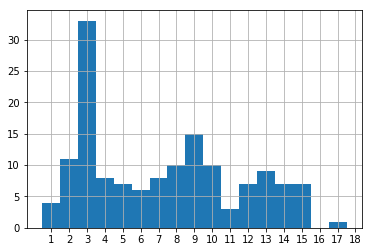

In [13]:
# plot distribution of missing values
binwidth=1
bins=np.arange(df.missing_cols.min(),df.missing_cols.max()+2*binwidth)
df.missing_cols.hist(bins=bins, align='left')
plt.xticks(bins);

In [14]:
# exploring rows with >= 17 missing (relevant) features
df.query('missing_cols>=17').sort_values(by='missing_cols')

,full_name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,missing_cols
84,LOCKHART EUGENE E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,17


In [15]:
rows_to_remove = [84]

In [16]:
def make_visualisations(df, features, vis='hist', n_cols=2, figsize=(15,40), 
                        bins=50, **kwds):
    '''
    Make histrograms or boxplots for all items in features list from a pandas 
    dataframe.
    Parameters
    - df: Pandas dataframe. Dataframe with all data.
    - features: List. List of features to be plotted. Must be numerical 
    features. NaN values will be dropped.
    - vis: Str. Type of visualisation: [hist or boxplot]
    - n_cols: Integer. Number of columns for the histogram matrix.
    - figsize: Tuple (w,h). Size of histograms matrix.
    - bins: Integer. Number of bins in the histogram.
    '''
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=.3)
    for i in range(len(features)):
        ax=fig.add_subplot(round(len(features)/n_cols+.5),n_cols,i+1)
        data=df[features[i]].dropna()
        if vis=='hist':
            ax.hist(data,bins=bins, **kwds)
        elif vis=='boxplot':
            ax.boxplot(data, **kwds)
        else:
            print('Invalid visualisation')
            break
        ax.title.set_text(features[i])
    plt.show()
    
def outliers(df, feature):
    """
    Returns rows that are considered outliers for a given feature.
    Outlier definition: (Q1-1.5IQR,Q3+1.5IQR)
    Parameters:
    - df: Pandas dataframe. Dataframe that contains data.
    - feature: Str. Name of feature to be explored.
    """
    iqr = stats.iqr(df[feature].dropna())
    third_quantile = df[feature].quantile(0.75)
    first_quantile = df[feature].quantile(0.25)
    outliers = (first_quantile-1.5*iqr,third_quantile+1.5*iqr)
    return df[(df[feature]<outliers[0]) | (df[feature]>outliers[1])][['full_name',feature]]\
    .sort_values(by=feature)

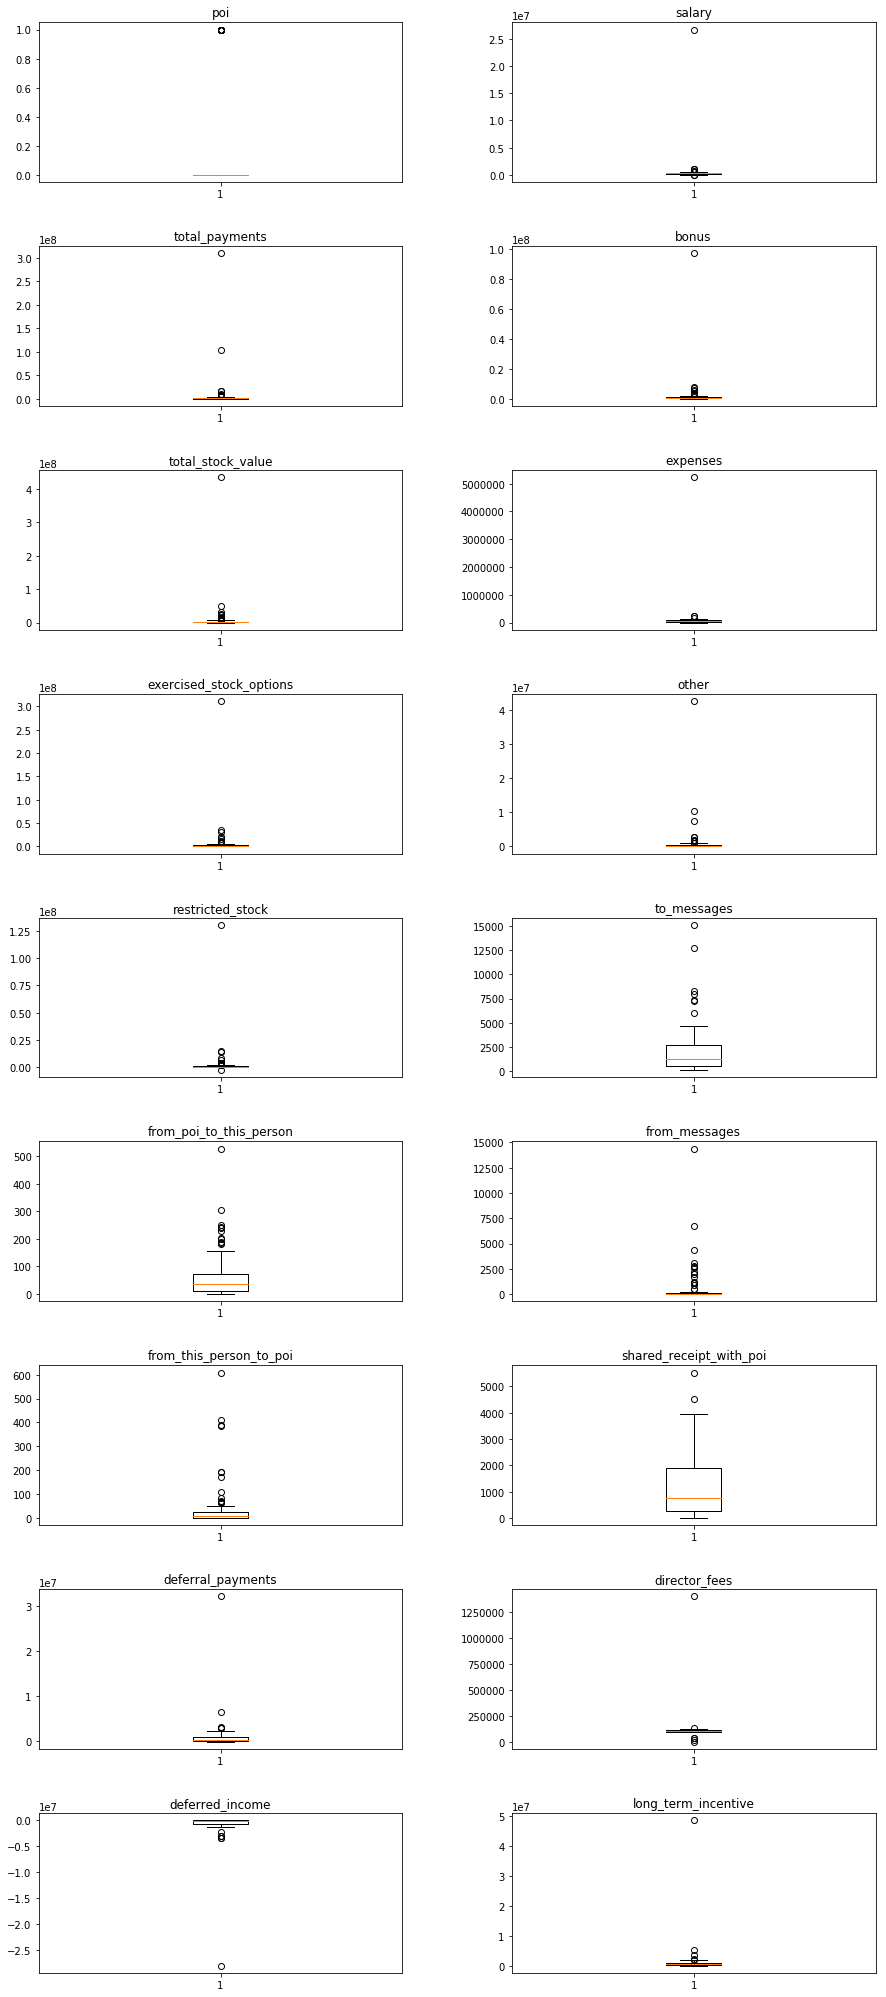

In [17]:
# boxplot of all features in features_list to identify outliers
make_visualisations(df, features_list, vis = 'boxplot')

In [18]:
outliers(df, 'salary')

,full_name,salary
2,BANNANTINE JAMES M,477.0
57,GRAY RODNEY,6615.0
32,DERRICK JR. JAMES V,492375.0
139,WHALLEY LAWRENCE G,510364.0
105,PICKERING MARK R,655037.0
47,FREVERT MARK A,1060932.0
79,LAY KENNETH L,1072321.0
122,SKILLING JEFFREY K,1111258.0
130,TOTAL,26704229.0


In [19]:
rows_to_remove.append(130)

In [20]:
# checking any other data problems visually
[(k,f) for k,f  in df.full_name.items()]

[(0, 'ALLEN PHILLIP K'),
 (1, 'BADUM JAMES P'),
 (2, 'BANNANTINE JAMES M'),
 (3, 'BAXTER JOHN C'),
 (4, 'BAY FRANKLIN R'),
 (5, 'BAZELIDES PHILIP J'),
 (6, 'BECK SALLY W'),
 (7, 'BELDEN TIMOTHY N'),
 (8, 'BELFER ROBERT'),
 (9, 'BERBERIAN DAVID'),
 (10, 'BERGSIEKER RICHARD P'),
 (11, 'BHATNAGAR SANJAY'),
 (12, 'BIBI PHILIPPE A'),
 (13, 'BLACHMAN JEREMY M'),
 (14, 'BLAKE JR. NORMAN P'),
 (15, 'BOWEN JR RAYMOND M'),
 (16, 'BROWN MICHAEL'),
 (17, 'BUCHANAN HAROLD G'),
 (18, 'BUTTS ROBERT H'),
 (19, 'BUY RICHARD B'),
 (20, 'CALGER CHRISTOPHER F'),
 (21, 'CARTER REBECCA C'),
 (22, 'CAUSEY RICHARD A'),
 (23, 'CHAN RONNIE'),
 (24, 'CHRISTODOULOU DIOMEDES'),
 (25, 'CLINE KENNETH W'),
 (26, 'COLWELL WESLEY'),
 (27, 'CORDES WILLIAM R'),
 (28, 'COX DAVID'),
 (29, 'CUMBERLAND MICHAEL S'),
 (30, 'DEFFNER JOSEPH M'),
 (31, 'DELAINEY DAVID W'),
 (32, 'DERRICK JR. JAMES V'),
 (33, 'DETMERING TIMOTHY J'),
 (34, 'DIETRICH JANET R'),
 (35, 'DIMICHELE RICHARD G'),
 (36, 'DODSON KEITH'),
 (37, 'DONAHUE JR J

In [21]:
rows_to_remove.append(127)

In [22]:
df.drop(rows_to_remove, axis=0, inplace=True)

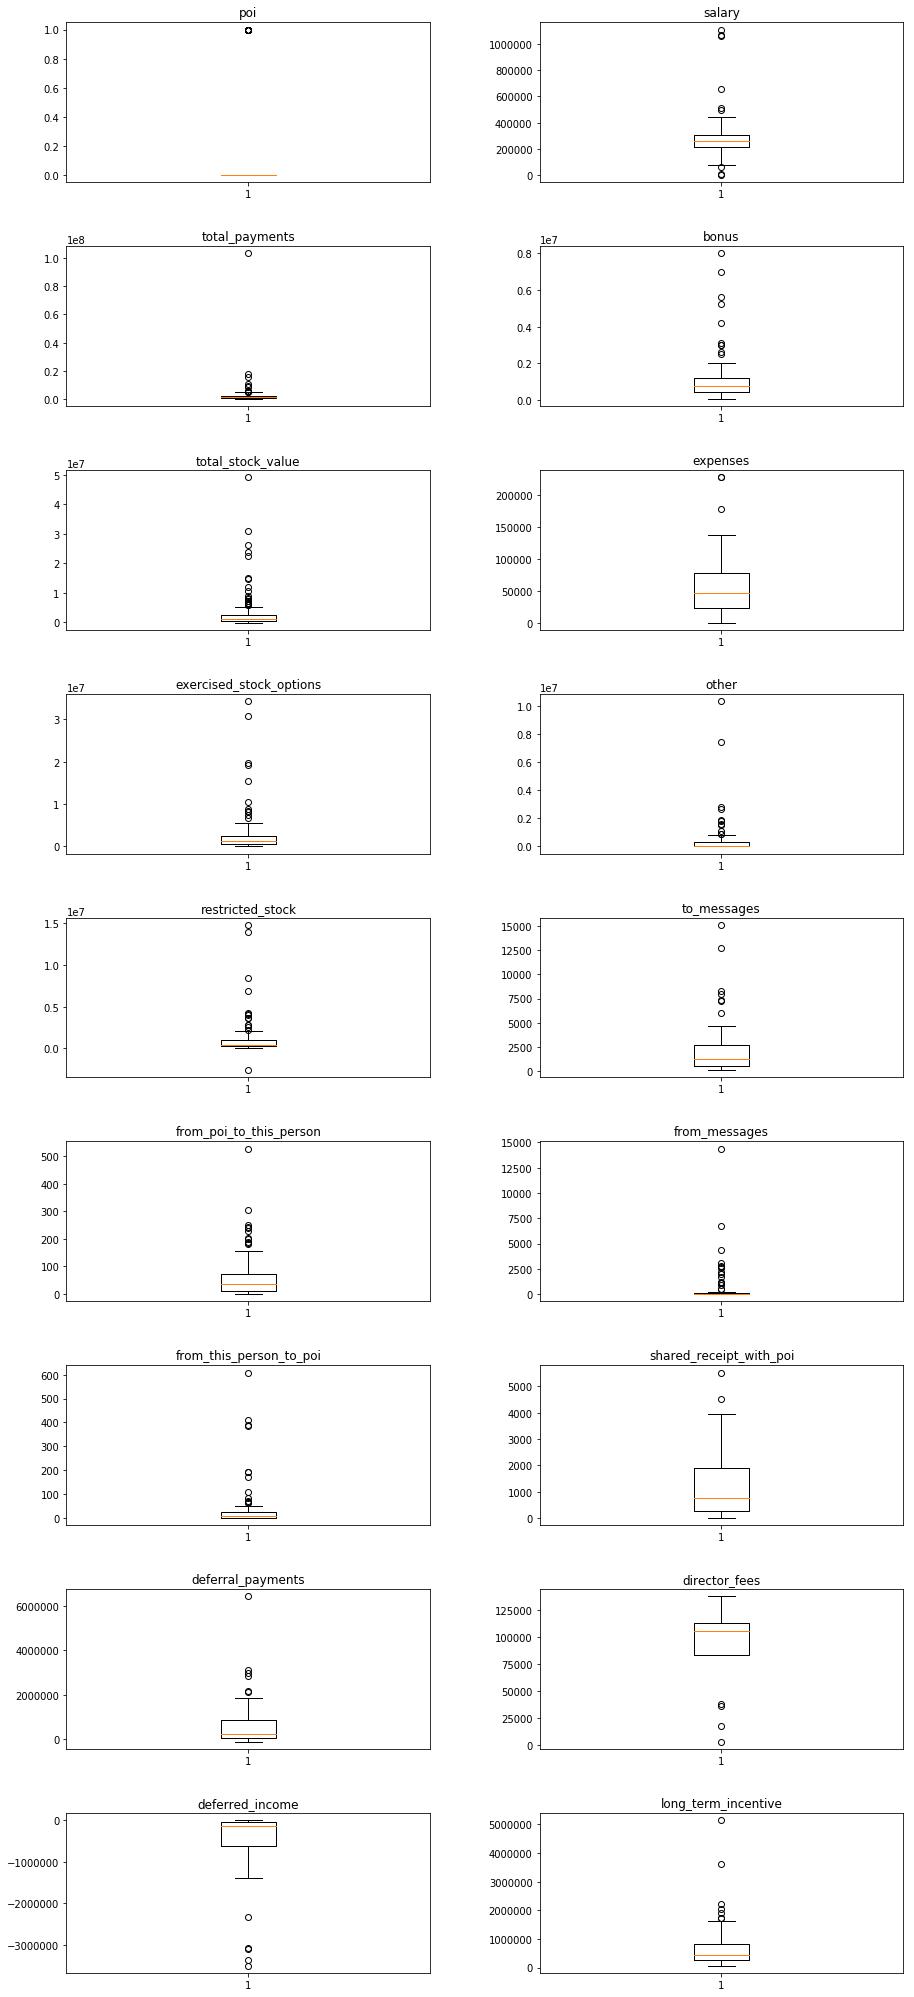

In [23]:
make_visualisations(df, features_list, vis='boxplot')

In [24]:
for feat in features_list:
    print(outliers(df,feat))

                full_name   poi
7        BELDEN TIMOTHY N  True
119            SHELBY REX  True
113        RIEKER PAULA H  True
112        RICE KENNETH D  True
79          LAY KENNETH L  True
77       KOPPER MICHAEL J  True
76          KOENIG MARK E  True
65           HIRKO JOSEPH  True
59         HANNON KEVIN P  True
54        GLISAN JR BEN F  True
43        FASTOW ANDREW S  True
31       DELAINEY DAVID W  True
26         COLWELL WESLEY  True
22       CAUSEY RICHARD A  True
20   CALGER CHRISTOPHER F  True
15     BOWEN JR RAYMOND M  True
122    SKILLING JEFFREY K  True
144        YEAGER F SCOTT  True
               full_name     salary
2     BANNANTINE JAMES M      477.0
57           GRAY RODNEY     6615.0
137   WESTFAHL RICHARD K    63744.0
32   DERRICK JR. JAMES V   492375.0
139   WHALLEY LAWRENCE G   510364.0
105     PICKERING MARK R   655037.0
47        FREVERT MARK A  1060932.0
79         LAY KENNETH L  1072321.0
122   SKILLING JEFFREY K  1111258.0
              full_name  total_p

In [25]:
# correcting Bhatnagar, Sanjay's entry
[(n,c) for n,c in enumerate(df.columns)]

[(0, 'full_name'),
 (1, 'salary'),
 (2, 'to_messages'),
 (3, 'deferral_payments'),
 (4, 'total_payments'),
 (5, 'loan_advances'),
 (6, 'bonus'),
 (7, 'email_address'),
 (8, 'restricted_stock_deferred'),
 (9, 'deferred_income'),
 (10, 'total_stock_value'),
 (11, 'expenses'),
 (12, 'from_poi_to_this_person'),
 (13, 'exercised_stock_options'),
 (14, 'from_messages'),
 (15, 'other'),
 (16, 'from_this_person_to_poi'),
 (17, 'poi'),
 (18, 'long_term_incentive'),
 (19, 'shared_receipt_with_poi'),
 (20, 'restricted_stock'),
 (21, 'director_fees'),
 (22, 'missing_cols')]

In [26]:
df.query('full_name=="BHATNAGAR SANJAY"')

,full_name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,missing_cols
11,BHATNAGAR SANJAY,NaN,523.0,NaN,15456290.0,NaN,NaN,sanjay.bhatnagar@enron.com,15456290.0,NaN,...,2604490.0,29.0,137864.0,1.0,False,NaN,463.0,-2604490.0,137864.0,7


In [27]:
nan_cols = [1,6,18,9,3,5,15,21]
valid_cols=[11,4,13,20,8,10]
cols_values=[137864, 137864, 15456290, 2604490, -2604490, 15456290]
df.iloc[11,valid_cols]=cols_values
df.iloc[11,nan_cols]=np.nan
df.iloc[11]

full_name                              BHATNAGAR SANJAY
salary                                              NaN
to_messages                                         523
deferral_payments                                   NaN
total_payments                                   137864
loan_advances                                       NaN
bonus                                               NaN
email_address                sanjay.bhatnagar@enron.com
restricted_stock_deferred                  -2.60449e+06
deferred_income                                     NaN
total_stock_value                           1.54563e+07
expenses                                         137864
from_poi_to_this_person                               0
exercised_stock_options                     1.54563e+07
from_messages                                        29
other                                               NaN
from_this_person_to_poi                               1
poi                                             

In [28]:
outliers(df,'restricted_stock')

,full_name,restricted_stock
60,HAUG DAVID L,2217299.0
22,CAUSEY RICHARD A,2502063.0
11,BHATNAGAR SANJAY,2604490.0
112,RICE KENNETH D,2748364.0
139,WHALLEY LAWRENCE G,2796177.0
144,YEAGER F SCOTT,3576206.0
69,IZZO LAWRENCE L,3654808.0
3,BAXTER JOHN C,3942714.0
73,KEAN STEVEN J,4131594.0
47,FREVERT MARK A,4188667.0


# Task 3

Create new feature(s)

In [29]:
features_list

['poi',
 'salary',
 'total_payments',
 'bonus',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'restricted_stock',
 'to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'deferral_payments',
 'director_fees',
 'deferred_income',
 'long_term_incentive']

In [30]:
# proportion of received messages from poi out of total received messages
# and sent messages to poi out of total sent messages
df['from_poi_proportion']=df.from_poi_to_this_person/df.to_messages
df['to_poi_proportion']=df.from_this_person_to_poi/df.from_messages

# bonus to salary ratio
df['bonus_to_salary']=df.bonus/df.salary

# restricted stock as a proportion of total stock value
df['restricted_to_total_stock']=df.restricted_stock/df.total_stock_value


In [31]:
# updated features list
features_list = features_list + ['from_poi_proportion','to_poi_proportion',
                                 'bonus_to_salary','restricted_to_total_stock']

In [32]:
df.loc[df[df.email_address=='NaN'].index,'email_address']=np.nan
df['poi']=df.poi.apply(lambda x: 1 if x else 0)
data_dict = df.set_index('full_name').to_dict(orient='index')

In [33]:
# convert np.nan to 'NaN' for compatibility with tester
for k,v in data_dict.items():
    for sk,sv in v.items():
        if sv!=sv:
            data_dict[k][sk]='NaN'

In [34]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
#data = featureFormat(my_dataset, features_list, sort_keys = True)
#labels, features = targetFeatureSplit(data)

features = np.array(df[features_list].fillna(0).iloc[:,1:])
labels = np.array(df[features_list].fillna(0).iloc[:,0])

In [35]:
# using select kbest with f_classif algorithms to sort out the top features
from sklearn import feature_selection

In [36]:
select = feature_selection.SelectKBest()

In [37]:
select.fit(features, labels)

SelectKBest(k=10, score_func=<function f_classif at 0x1a1b73d268>)

In [38]:
feat_selection = pd.DataFrame([{'feature':f,'score':s,'p_value':p} 
                               for f,s,p in zip(features_list[1:],
                                                select.scores_, 
                                                select.pvalues_)])

In [39]:
feat_selection.query('p_value<=0.05').sort_values(by='score', ascending=False)

,feature,p_value,score
3,total_stock_value,0.000005,22.511922
5,exercised_stock_options,0.000005,22.348834
2,bonus,0.000011,20.792252
0,salary,0.000035,18.289684
18,to_poi_proportion,0.000084,16.409713
15,deferred_income,0.000922,11.458477
19,bonus_to_salary,0.001292,10.783585
16,long_term_incentive,0.001994,9.922186
1,total_payments,0.002763,9.281862
7,restricted_stock,0.003487,8.828679


In [40]:
features_list = ['poi'] + list(feat_selection.query('p_value<=0.05').feature)
features_list

['poi',
 'salary',
 'total_payments',
 'bonus',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'restricted_stock',
 'from_poi_to_this_person',
 'shared_receipt_with_poi',
 'deferred_income',
 'long_term_incentive',
 'to_poi_proportion',
 'bonus_to_salary']

In [41]:
features = np.array(df[features_list].fillna(0).iloc[:,1:])
labels = np.array(df[features_list].fillna(0).iloc[:,0])

# Task 4

Try a varity of classifiers.<br>
Please name your classifier clf for easy export below.<br>
Note that if you want to do PCA or other multi-stage operations,
you'll need to use Pipelines. For more info:<br>
http://scikit-learn.org/stable/modules/pipeline.html

In [ ]:
# Provided to give you a starting point. Try a variety of classifiers.
#from sklearn.naive_bayes import GaussianNB
#clf = GaussianNB()

# Task 5

Tune your classifier to achieve better than .3 precision and recall
using our testing script. Check the tester.py script in the final project
folder for details on the evaluation method, especially the test_classifier
function. Because of the small size of the dataset, the script uses
stratified shuffle split cross validation. For more info:  <br>
http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

In [42]:
# Example starting point. Try investigating other evaluation techniques!
from sklearn import model_selection

In [43]:
features_train, features_test, labels_train, labels_test = \
    model_selection.train_test_split(features, labels, test_size=0.3, 
                                     random_state=42)

In [44]:
from sklearn import metrics

#### GaussianNB

In [45]:
from sklearn.naive_bayes import GaussianNB

In [48]:
poi_prop=df.poi.sum()/df.poi.size
params_grid={'priors':[None,[.5,.5],[.9,.1],[1-poi_prop, poi_prop]]}

In [49]:
clf = model_selection.GridSearchCV(GaussianNB(),params_grid, 
                                   return_train_score=True)

In [50]:
clf.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score='raise', estimator=GaussianNB(priors=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'priors': [None, [0.5, 0.5], [0.9, 0.1], [0.8741258741258742, 0.1258741258741259]]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [51]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']

print('best parameters: ', clf.best_params_)
print()
for mean, std, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

best parameters:  {'priors': None}

0.780 (+/-0.184) for {'priors': None}
0.750 (+/-0.198) for {'priors': [0.5, 0.5]}
0.780 (+/-0.184) for {'priors': [0.9, 0.1]}
0.780 (+/-0.184) for {'priors': [0.8741258741258742, 0.1258741258741259]}



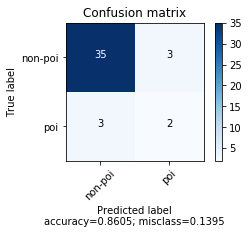

In [52]:
preds=clf.predict(features_test)
cm=metrics.confusion_matrix(labels_test, preds)

plot_confusion_matrix(cm, ['non-poi','poi'], normalize=False,figsize=(4,3))

In [53]:
print(metrics.classification_report(labels_test, preds))

             precision    recall  f1-score   support

          0       0.92      0.92      0.92        38
          1       0.40      0.40      0.40         5

avg / total       0.86      0.86      0.86        43



In [54]:
test_classifier(clf, my_dataset, features_list)

Accuracy: 0.84000	Precision: 0.35714
Recall: 0.25000	F1: 0.29412	F2: 0.26596

Total predictions:  150	True positives:    5	False positives:    9
False negatives:   15	True negatives:  121



#### Decision Tree

In [55]:
from sklearn import tree

In [59]:
params_grid={
    'criterion':['gini','entropy'],
    'min_samples_leaf':[1,2,4,6,8],
    'max_depth':[None,2,4,8],
    'min_samples_split':[2,4,6,8]   
}
clf = model_selection.GridSearchCV(tree.DecisionTreeClassifier(),params_grid)

In [60]:
clf.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 4, 6, 8], 'max_depth': [None, 2, 4, 8], 'min_samples_split': [2, 4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [61]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']

print('best parameters: ', clf.best_params_)
print()
for mean, std, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

best parameters:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 6}

0.780 (+/-0.125) for {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.770 (+/-0.104) for {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4}
0.800 (+/-0.026) for {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 6}
0.810 (+/-0.070) for {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 8}
0.810 (+/-0.070) for {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.780 (+/-0.101) for {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 4}
0.780 (+/-0.069) for {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 6}
0.780 (+/-0.069) for {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 8}
0.810 (+/-0.118) f

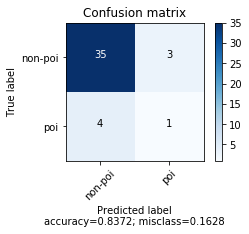

In [62]:
preds=clf.predict(features_test)
cm=metrics.confusion_matrix(labels_test, preds)

plot_confusion_matrix(cm, ['non-poi','poi'], normalize=False,figsize=(4,3))

In [63]:
print(metrics.classification_report(labels_test, preds))

             precision    recall  f1-score   support

          0       0.90      0.92      0.91        38
          1       0.25      0.20      0.22         5

avg / total       0.82      0.84      0.83        43



In [64]:
test_classifier(clf, my_dataset, features_list)

Accuracy: 0.86000	Precision: 0.47059
Recall: 0.40000	F1: 0.43243	F2: 0.41237

Total predictions:  150	True positives:    8	False positives:    9
False negatives:   12	True negatives:  121



In [65]:
dump_classifier_and_data(clf, my_dataset, features_list,
                         ['decision_tree.pkl','my_dataset.pkl',
                          'my_feature_list.pkl'])

#### Random Forest

In [67]:
from sklearn import ensemble

In [68]:
params_grid={
    'n_estimators':[5,10,20,40,80,160,320],
    'criterion':['gini','entropy'],
    'min_samples_leaf':[1,2,4,6,8]
}

In [69]:
clf = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), 
                                   params_grid, return_train_score=True)

In [70]:
clf.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20, 40, 80, 160, 320], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [71]:
clf.best_params_

{'criterion': 'gini', 'min_samples_leaf': 4, 'n_estimators': 20}

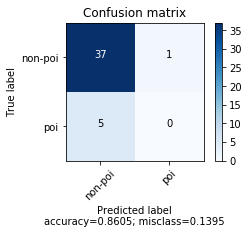

In [72]:
preds=clf.predict(features_test)
cm=metrics.confusion_matrix(labels_test, preds)

plot_confusion_matrix(cm, ['non-poi','poi'], normalize=False,figsize=(4,3))

In [73]:
test_classifier(clf, my_dataset, features_list)

Accuracy: 0.86667	Precision: 0.50000
Recall: 0.15000	F1: 0.23077	F2: 0.17442

Total predictions:  150	True positives:    3	False positives:    3
False negatives:   17	True negatives:  127



In [74]:
dump_classifier_and_data(clf, my_dataset, features_list,
                         ['random_forest.pkl','my_dataset.pkl',
                          'my_feature_list.pkl'])

#### AdaBoost

In [75]:
params_grid={'n_estimators':[25,50,100,150,200,300]}

In [76]:
clf = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), 
                                   params_grid, return_train_score=True)

In [77]:
clf.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [25, 50, 100, 150, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [78]:
test_classifier(clf, my_dataset, features_list)

Accuracy: 0.88667	Precision: 0.66667
Recall: 0.30000	F1: 0.41379	F2: 0.33708

Total predictions:  150	True positives:    6	False positives:    3
False negatives:   14	True negatives:  127



In [79]:
dump_classifier_and_data(clf, my_dataset, features_list,
                         ['ada_boost.pkl','my_dataset.pkl',
                          'my_feature_list.pkl'])

# Task 6
Dump your classifier, dataset, and features_list so anyone can
check your results. You do not need to change anything below, but make sure
that the version of poi_id.py that you submit can be run on its own and
generates the necessary .pkl files for validating your results.